# Table of Contents
- [Introduction](#introduction)
  - [Load the data](#load-the-data)
  - [Plotting of the data](#plotting-of-the-data)
- [Tokenizing the data](#tokenizing-the-data)
- [Visualizing the tokens within the data](#visualizing-the-tokens-within-the-data)
- [PCA analysis of the data](#pca-analysis-of-the-data)
- [Model training and evaluation](#model-training-and-evaluation)
  - [Hyperparameter Tuning](#hyperparameter-tuning)
  - [Test Data Prediction](#test-data-prediction)
- [Get the results from the competition and compare to supervised learning model](#get-the-results-from-the-competition-and-compare-to-supervised-learning-model)
- [Supervised learning model and comparison with unsupervised](#supervised-learning-model-and-comparison-with-unsupervised)
  - [Implementation and evaluation of the random forest model](#implementation-and-evaluation-of-the-random-forest-model)
  - [Random forest classifier accuracy results](#random-forest-classifier-accuracy-results)
  - [Use the best model of the linear SVM to evaluate it with the test data and submit it to Kaggle](#use-the-best-model-of-the-linear-svm-to-evaluate-it-with-the-test-data-and-submit-it-to-kaggle)
- [REFERENCES](#references)

# Introduction
This contains the code for section 1 Part 1 of the kaggle mini project. In here, I perform exploratory data analysis of the BBC data and create features out of the text in each article. The analysis is performed for the train data set.

Note that all of the code in this notebook is contained within a public github repo in: https://github.com/Adalberto-Machin/Kaggle_BBC_news_competition/tree/EDA_work

## Load the data
This section of the code loads the data for the analysis

In [1]:
# import all libraries used in this code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load the training data
df_train = pd.read_csv("data/BBC News Train.csv")

#factorize the article categories in order to make the prediction a lot easier
df_train['category_id'] = df_train.Category.factorize()[0]

# keep a key dictionary of the factorize operation just in case
# filter the ids and categories to not have repetition
track_item = set()
id_list = [id for id in df_train.Category.factorize()[0] if id not in track_item and not track_item.add(id)]
track_cat = set()
cat_list = [cat for cat in df_train.Category.factorize()[1] if cat not in track_cat and not track_cat.add(cat)]
category_to_id = dict(zip(id_list, track_cat))

## Plotting of the data
Let's create some plots about the number of documents per class, and also do some initial data description stats

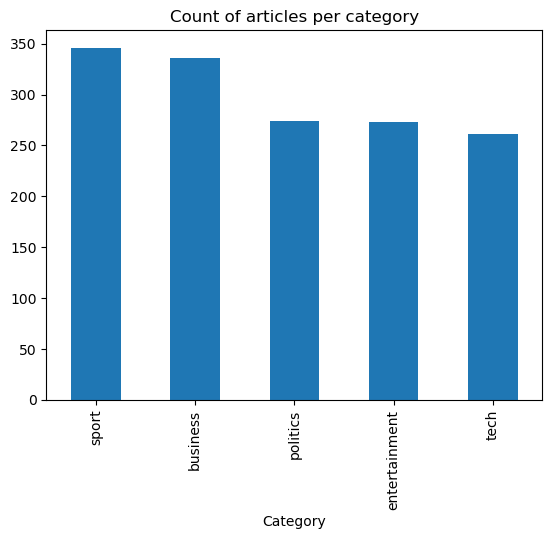

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   category_id  
0            0  
1            0  
2            0  
3            1  
4            0  


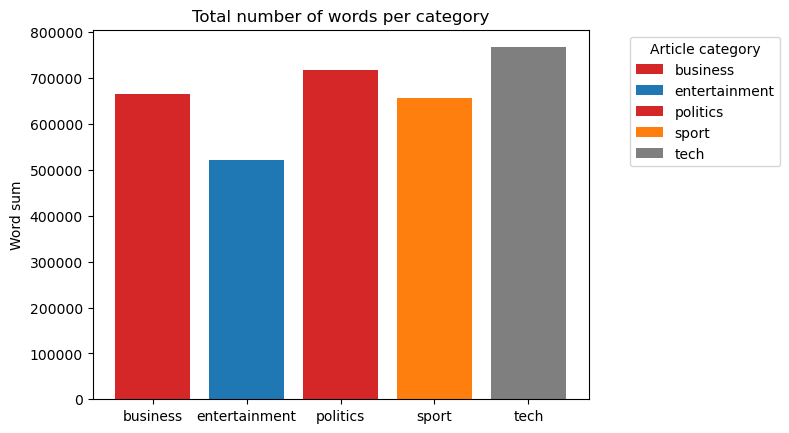

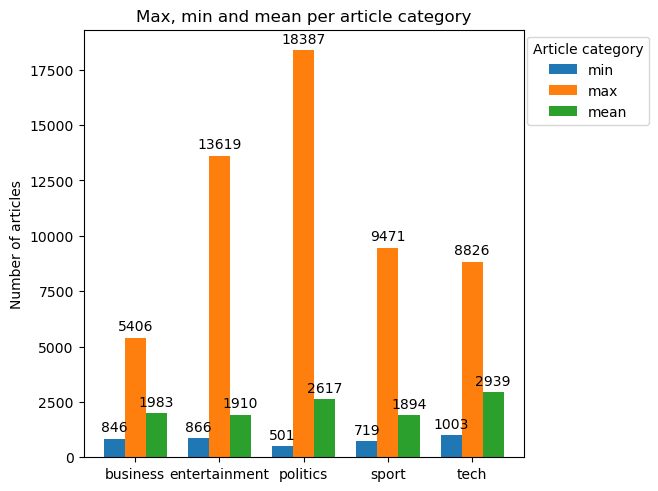

In [3]:
df_train.Category.value_counts().plot(kind='bar',title="Count of articles per category")
plt.show()

# lets also print the first 5 entries of the dataframe
print(df_train.head())

# do initial stats on the data: count the total number of words per category and then the min, mean, and max across the articles
df_train['Word_count'] = [len(article_words) for article_words in df_train.Text]

stats_to_plot = df_train.groupby(['Category', 'category_id'], as_index=False)['Word_count'].agg(['min', 'max', 'mean', 'sum'])
stats_to_plot['mean'] = np.floor(stats_to_plot['mean']).astype(int)

fig, ax = plt.subplots()
bar_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:gray']
ax.bar(stats_to_plot['Category'], stats_to_plot['sum'], label=bar_labels, color=bar_colors)
ax.set_ylabel('Word sum')
ax.set_title('Total number of words per category')
ax.legend(title='Article category', loc = 1, bbox_to_anchor = (1.4, 1))

keys = []
items = []
for key in stats_to_plot.columns:
    keys.append(key)
    items.append(list(stats_to_plot.loc[:, key]))
items_to_plot = dict(zip(keys, items))
data_to_plot  = items_to_plot.copy()

#Remove items we do not care about to make the plotting easier
iterable_keys = list(data_to_plot.keys())
for keys in iterable_keys:
    if keys in ['Category', 'category_id', 'sum']:
        data_to_plot.pop(keys, None)
    else:
        continue

x = np.arange(len(stats_to_plot['Category']))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data_to_plot.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of articles')
ax.set_title('Max, min and mean per article category')
ax.set_xticks(x + width, items_to_plot['Category'])
ax.legend(title='Article category', loc = 1, bbox_to_anchor = (1.3, 1))
plt.show()




## Tokenizing the data
After doing some initial data analysis, we need to tokenize the words for each article to be able to meaningfully train an AI model on the data to make accurate predictions. Tne approach I use a *"bag of words"* model: for each article, the presence and frequency of words is taken into consideration, but the order in which they occur is ignored. Note that the analysis I follow is similar and based on the analysis done here: `https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification`.

The model calculates *Term Frequency, Inverse Document Frequency*. This stat represents word importance in each document; the word frequency is used as a proxy for its importance, and document frequency (the number of documents containing a given word) as a measure of how common the word is, which minimizes the effect of stop-words. I leverage `TfidfVectonizer` from `sklearn` library for this, which calculates a tf-idf vector for each of the documents.

Also, the plan is to use the following parameters:
* `sublinear_tf = true` to use the log of the frequency--> this is because word frequency follows an exponential distribution
* normalize the vectors to `l2 norm` so that the length of the documents does not bias its representation
* consider bigrams using the feature `ngram_range` set to `(1,2)`. This will consider unigrams and bigrams in the analysis because these carry different meanings often in the context of articles
* `encoding = latin-1`
* `stop_words = "english"` to remove common pronouns and other common words that would be considered noisy features within the model

Initial model paramater that could be changed to evaluate model performance:
* `min_df = 3` to avoid rare words from affecting model performance

In [4]:
# code for tokenizing the data
# use utils to create class of data for train and test data
# tokenize the train data
import utils

df_train = pd.read_csv("data/BBC News Train.csv")
df_test = pd.read_csv("data/BBC News Test.csv")

#create the class

article_model = utils.Articles(df_train, df_test)

#encode the training labels
article_model.encode_labels('train')

#tokenize the data
summary = article_model.vectorize_words(article_model.factorized_train)

# print shape of the tokenized data
print(f'the tokenize method created a maxtrix of {article_model.word_tokens_sparse.toarray().shape[0]} articles and {article_model.word_tokens_sparse.toarray().shape[1]} features')

#visualize the tokenized data
print(summary.head())

the tokenize method created a maxtrix of 1490 articles and 5000 features
        000  000 jobs  000 new  000 people  000 year  000m   05        10  \
0  0.000000       0.0      0.0    0.000000       0.0   0.0  0.0  0.000000   
1  0.000000       0.0      0.0    0.000000       0.0   0.0  0.0  0.049412   
2  0.037446       0.0      0.0    0.066479       0.0   0.0  0.0  0.000000   
3  0.030301       0.0      0.0    0.000000       0.0   0.0  0.0  0.000000   
4  0.000000       0.0      0.0    0.000000       0.0   0.0  0.0  0.044312   

   10 000  10 000m  ...  youngsters  yuan  yugansk  yuganskneftegas  yukos  \
0     0.0      0.0  ...    0.000000   0.0      0.0              0.0    0.0   
1     0.0      0.0  ...    0.000000   0.0      0.0              0.0    0.0   
2     0.0      0.0  ...    0.000000   0.0      0.0              0.0    0.0   
3     0.0      0.0  ...    0.069958   0.0      0.0              0.0    0.0   
4     0.0      0.0  ...    0.000000   0.0      0.0              0.0    0.0

## Visualizing the tokens within the data

We will use a horizontal bar plot to visualize the unigrams and bigrams with the highest scores from the TfidfVectorizer method and will use PCA to visualize if the data can be divided easily into 5 categories.

Text(0.5, 0, 'Influence')

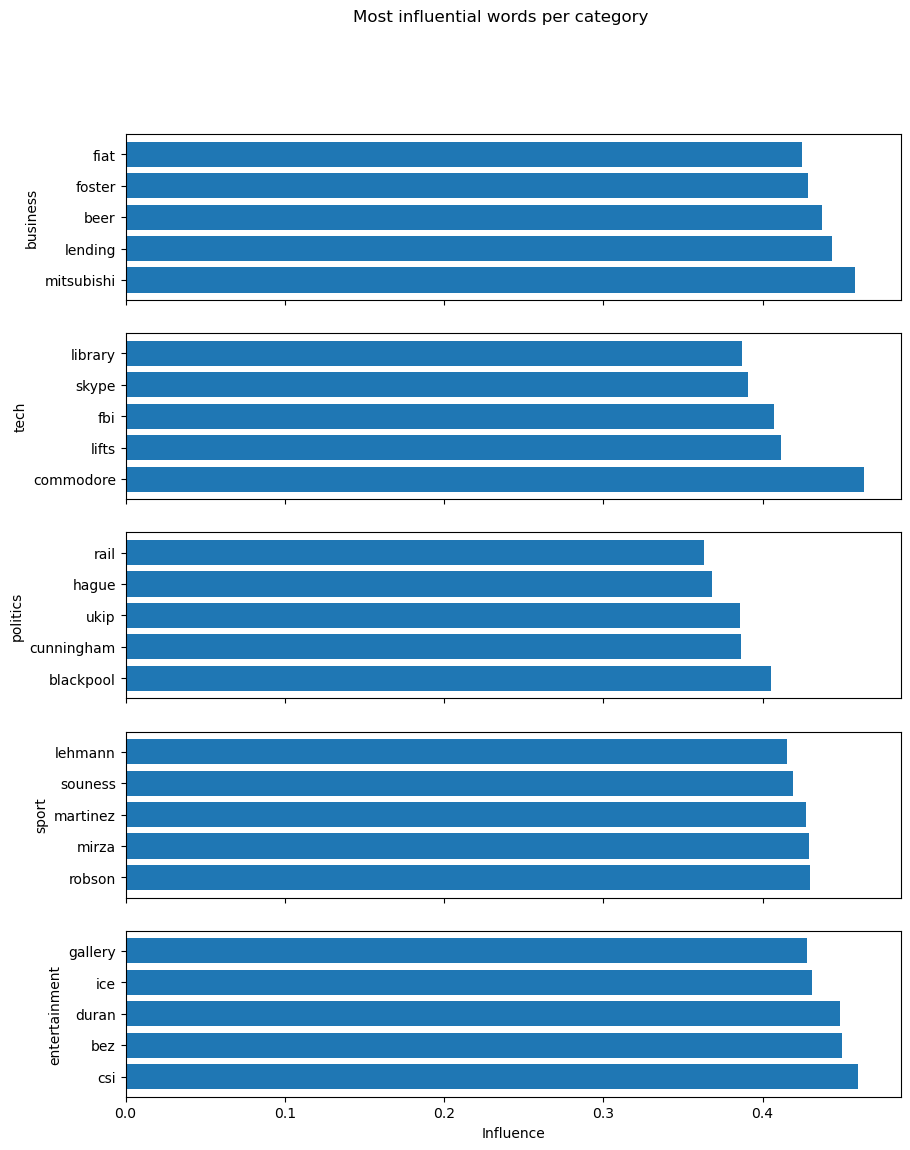

In [5]:
# get the 5 most influential tokens per category to plot them
# use dictionary of category to ID to plot the actual category and not the factorized ID
N = 5
token_scores = summary.drop(columns = ['ArticleId']).groupby(['category_id']).max()
top_words = {}
for cat_id, row in token_scores.iterrows():
    row_np = np.array(row)
    scores = []
    scores.append(row_np[np.argsort(row_np)[-N:]])
    scores.append(token_scores.columns[np.argsort(row_np)[-N:]])
    top_words[article_model.id_to_cat[cat_id]] = scores


fig, ax = plt.subplots(len(top_words), figsize=(10, 2.5 * len(top_words)), sharex=True)
fig.suptitle('Most influential words per category')

for ax_instance, (category, (scores, words)) in zip(ax, top_words.items()):
    ax_instance.barh(words, scores)
    ax_instance.invert_yaxis()
    ax_instance.set_ylabel(category)
ax_instance.set_xlabel('Influence')

## PCA analysis of the data

The code below performs a PCA analysis of the data to determine if the features of the articles( as determined by tokenizing the words of each articles) can be grouped in the assumed 5 different categories. I will use PCA in order to confirm that the feature space being used (tokenizing the articles for each category) is representative enough for the task to be solvable. Given that we are dealing with language, correlations between the features are expected to be non-linear, so I will use `Kernel PCA`: Self-organizing maps and auto-encoders; however, for this case, I will only evaluate a subset of the data due to the high computational cost of this method and inability to analyze sparse matrices. I will also perform `Truncated SVD` with all of the data, which is more computational efficient, but it is better suited for features that are linearly correlated. This will allow me to compare the results.

From looking at both PCA analysis, we can conclude that it would be possible to predict if the data can be grouped into one of 5 different categories since the PCA analyses clearly show 5 main clusters. However, the `Kernel PCA` results look more seperable, as expected, since the features of the data (word toklens) are not linearly related.

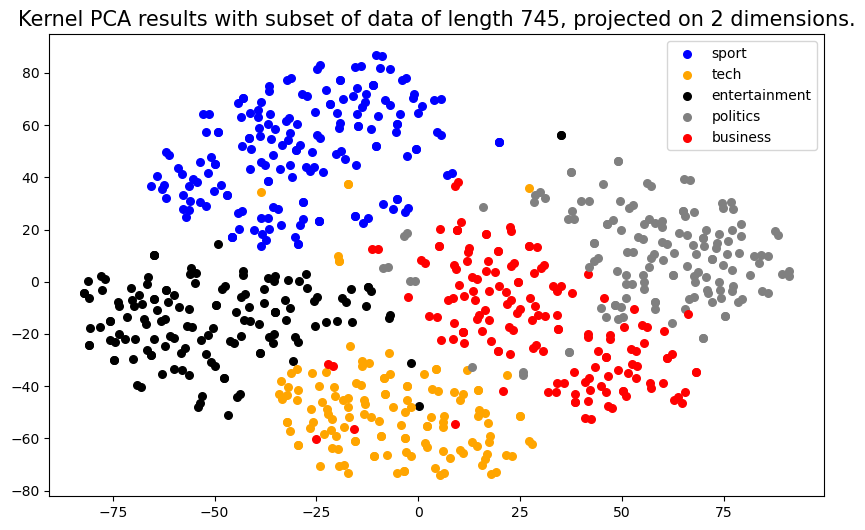

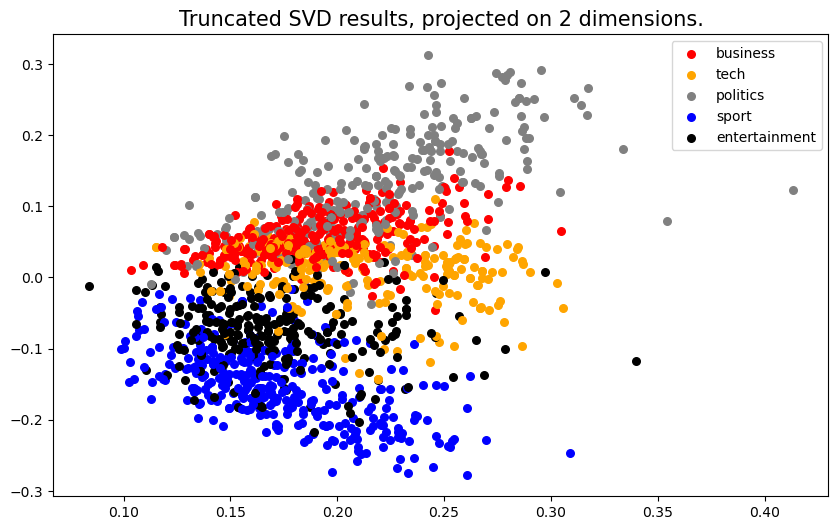

In [6]:
# doing Kernel PCA to see if there are at least 5 different clusters in which the data can be grouped on
from sklearn.manifold import TSNE

# Get raw summary data without columns that would influence model
summary_PCA = summary.drop(['category_id', 'ArticleId'], axis=1).copy()
# sample only a subset of the data because t-SNE is computationally expensive; analyze only 30% of the training samples
sample_size_PCA = int(len(summary_PCA) * 0.5)
# create a random subset of size sample_size_PCA from the tokenized data to analyze
np.random.seed(55)
sample_index_PCA = np.random.choice(range(len(summary_PCA)), size=sample_size_PCA)

# Perform the Kernel PCA analysis of the data
kernel_PCA_model = TSNE(n_components=2, learning_rate='auto', random_state=0).fit_transform(np.array(summary_PCA.iloc[sample_index_PCA,:]))

# Plot the embedded feature space
#create set for storing labels so that they do not get repeated
label_set = set()

# create figure and colors for the legend
colors = ['red', 'orange', 'gray', 'blue', 'black']
plt.figure(figsize=(10, 6))

#loop to create the scatter plot
for idx, sample  in enumerate(summary.iloc[sample_index_PCA,:]['category_id']):
    # get the points to plot in the iteration
    points = kernel_PCA_model[idx]
    # get the labels of the points
    label = article_model.id_to_cat[sample]
    # if label has not been seen, add it; otherwise plot the point but skip the label
    if label not in label_set:
        plt.scatter(points[0], points[1], s=30, c=colors[sample], label=label)
        label_set.add(label)
    else:
        plt.scatter(points[0], points[1], s=30, c=colors[sample])

# Add title and legends to the plot
plt.title(f"Kernel PCA results with subset of data of length {sample_size_PCA}, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

# perform Truncated SVD with all of the data
from sklearn.decomposition import TruncatedSVD

# create the PCA model and do dimensionality reduction on the original raw data return from the vectorization of the class
truncated_PCA_model = TruncatedSVD(n_components=2, random_state=42).fit_transform(article_model.word_tokens_sparse.toarray())

# Plot the embedded feature space
#create set for storing labels so that they do not get repeated
label_set = set()

# create figure and colors for the legend
colors = ['red', 'orange', 'gray', 'blue', 'black']
plt.figure(figsize=(10, 6))

#loop to create the scatter plot
for idx, sample  in enumerate(summary['category_id']):
    # get the points to plot in the iteration
    points = truncated_PCA_model[idx]
    # get the labels of the points
    label = article_model.id_to_cat[sample]
    # if label has not been seen, add it; otherwise plot the point but skip the label
    if label not in label_set:
        plt.scatter(points[0], points[1], s=30, c=colors[sample], label=label)
        label_set.add(label)
    else:
        plt.scatter(points[0], points[1], s=30, c=colors[sample])

# Add title and legends to the plot
plt.title(f"Truncated SVD results, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

## Model training and evaluation

In this section of the document, I will perform training and evaluation of a NMF model and a supervised learning model and compare their respective performances on the test data.

Steps I follow/answers to the assigment about this section: 
1) When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not? - I should not include this information because although NMF is an unsupervised learning approach, there is still a loss function associated with it, and I can use the test data to evaluate how well my model performs.
2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
    * The hyperparameters I chose are the following:
        * `n_components =5` because we have 5 different expected categories, and we use NMF model for semantic decomposition in this case rather than for dimensionality reduction
        * `init=nndsvd` because the tokenized matrix of words is a sparse matrix, and this is better for sparseness and this initialization method is better for TF-IDF based topic modeling
        * `solver=cd` because this is the default and works well with TF-IDF data
        * When it comes to regularization, I plan to use the following initial parameters:
            * `alpha_W=default`: controls complexity of document topic weights
            * `alpha_H=default`: controls the complexity of topic word weights
            * `l1_ratio=default`: controls how much of the penalty is L1(sparse) vs L2(smooth)

3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
    * I plan to measure the performance of the model using accuracy
4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
    * The hyperparameters I changed are related to regularization, and the ones that obtain the best accuracy score are:
        * `alpha_W=0.0`: Higher `alpha_W` causes each document to belong to fewer topics
        * `alpha_H=0.01`: Higher `alpha_H` causes the model to identify topics using fewer words, but not too high that would cause over-fitting
        * `l1_ratio=0.0`: controls how much of the penalty is L1(sparse) vs L2(smooth). 0.5 gets a balanced of both loss functions



The best permutation is (1, 3, 2, 4, 0),      
 which corresponds to ['tech', 'sport', 'politics', 'entertainment', 'business']      
 and has an accuracy of 0.9442953020134228


Text(0.5, 23.52222222222222, 'Predicted')

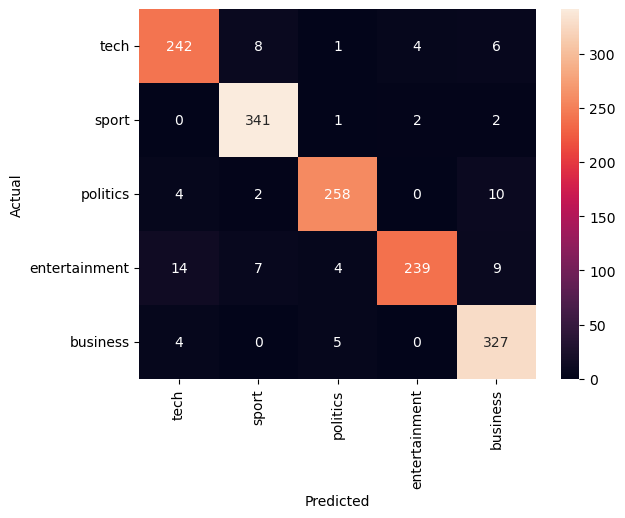

In [9]:
# run the model with default parameters
W,H = article_model.NMF_execute(article_model.word_tokens_sparse)

# get the predictes category for each article
predicted_topics = W.argmax(axis=1)

# determine what the model's assumed position actually maps to the actual categories
# and calculate its accuracy
perm, acc = article_model.label_permute_compare(article_model.factorized_train, predicted_topics)

print(f'The best permutation is {perm},\
      \n which corresponds to {[article_model.id_to_cat[it] for it in perm]}\
      \n and has an accuracy of {acc}')

# display confusion matrix associated with the result
CM_to_plot = article_model.confusion_matrix_mine(article_model.factorized_train, predicted_topics, perm)

#create a plot of the confusion matrix
import seaborn as sns

conf_mat = CM_to_plot
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[article_model.id_to_cat[it] for it in perm], yticklabels=[article_model.id_to_cat[it] for it in perm])
plt.ylabel('Actual')
plt.xlabel('Predicted')

Create the model with better hyperparameters and evaluate its performance.l Iterate over some hyper-parameters to compare

In [10]:
from sklearn.model_selection import ParameterGrid
parameter_iter = {'alpha_W':[0.0, 0.01, 0.05, 0.1, 1],
                  'alpha_H':[0.0, 0.01, 0.05, 0.1, 1],
                  'l1_ratio':[0.0, 0.01, 0.05, 0.1, 1]}
#create list to store the results
results = []
# do the hyperparameter iteration
for params in ParameterGrid(parameter_iter):
      # run the model with default parameters
      W,H = article_model.NMF_execute(article_model.word_tokens_sparse,
                                    alpha_W=params['alpha_W'], alpha_H=params['alpha_H'], l1_ratio=params['l1_ratio'], max_iter=500)

      # get the predicted category for each article
      predicted_topics = W.argmax(axis=1)

      # determine what the model's assumed position actually maps to the actual categories
      # and calculate its accuracy
      perm, acc = article_model.label_permute_compare(article_model.factorized_train, predicted_topics)
      results.append({
            'alpha_W': params['alpha_W'],
            'alpha_H': params['alpha_H'],
            'l1_ratio': params['l1_ratio'],
            'accuracy': acc,
            'permutation': perm
            })

# Create a dataframe that summarizes the results
results_summary = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
results_summary.head()

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: 

,alpha_W,alpha_H,l1_ratio,accuracy,permutation
6,0.01,0.00,0.01,0.953691,"(1, 3, 2, 4, 0)"
50,0.00,0.05,0.00,0.949664,"(1, 3, 2, 4, 0)"
25,0.00,0.01,0.00,0.949664,"(1, 3, 2, 4, 0)"
75,0.00,0.10,0.00,0.948322,"(1, 3, 2, 4, 0)"
20,1.00,0.00,0.00,0.946980,"(1, 3, 2, 4, 0)"


In [11]:
# use the top parameters to do the same with test data and evaluate performance
# run the model again with the best parameters


W,H = article_model.NMF_execute(article_model.word_tokens_sparse,
                                alpha_W=0.0, alpha_H=0.01, l1_ratio=0.00, max_iter=500)

# determine what the model's assumed position actually maps to the actual categories
# and calculate its accuracy
predicted_topics = W.argmax(axis=1)
perm, acc = article_model.label_permute_compare(article_model.factorized_train, predicted_topics)

print(f'The best permutation is {perm},\
      \n which corresponds to {[article_model.id_to_cat[it] for it in perm]}\
      \n and has an accuracy of {acc}')


#encode the testing labels
article_model.encode_labels('test')

# reuse the tokenizing of the train data so that matrices match
# article_model.word_tokens = article_model.tokenizer_model.transform(article_model.factorized_test.Text).toarray()
# article_model.word_model_sparse = article_model.tokenizer_model.transform(article_model.factorized_test.Text)
## the issus is with the lines above --- figure it out

test_instance_vector = article_model.tokenizer_model.transform(article_model.factorized_test.Text)


# run the model with the test data
W_test = article_model.model_NMF.transform(test_instance_vector)

# get the most likely topic and the corresondent actual topic based on the best permutation of the training data
predicted_topics = W_test.argmax(axis=1)

# match permutations correctly
predicted_topics_df = pd.DataFrame(predicted_topics)


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


The best permutation is (1, 3, 2, 4, 0),      
 which corresponds to ['tech', 'sport', 'politics', 'entertainment', 'business']      
 and has an accuracy of 0.9496644295302014


In [12]:
# map the model’s cluster index -> permuted category ID
cluster_to_id = dict(zip(range(len(perm)), perm))   # {0:3, 1:4, …}

# convert cluster IDs to the final category names
pred_cat_ids  = [cluster_to_id[c]      for c in predicted_topics]
pred_labels   = [article_model.id_to_cat[i] for i in pred_cat_ids]

results = pd.DataFrame({
    "ArticleId": article_model.factorized_test["ArticleId"],
    "Category":  pred_labels
})
results.to_csv("BBC_NEW_Solution.csv", index=False)


## Get the results from the competition and compare to supervised learning model

After submitting hte results to Kaggle, the model achieved an accuracy score of **0.94965**

## Supervised learning model and comparison with unsupervised

I will do two supervised learning models in order to compare the accuracy compared to the unsupervised learning model I created. I will use the following two models:
* Random forest: because it works well when complex feature-relations are involved, which is the case when we tokenize the words in each of the articles for each category.
* Linear SVM: because it works well with high-dimensional, sparse datasets and a small dataset, which is the case for the BBC news data-set.

## Implementation and evaluation of the random forest model

Pipeline: 
1) Load the data
2) Tokenize the data like we did before
3) Separate the training data in the training set to train the model and a validation set to optimize the hyperparameters of the model (do a hyperparameter search)
4) Evaluate the model's performance on the test data

In [2]:
import utils
# Load the data 
df_test = pd.read_csv("data/BBC News Test.csv")
df_train = pd.read_csv("data/BBC News Train.csv")

# Create the class for the supervised models
supervised_model_articles = utils.SupervisedArticles(df_train, df_test)

# separate training data into the initial training data and validation data for hyperparameter tuning
train_data, validation_data = supervised_model_articles.split_train_validation()

# map the article IDs to the rows in the vectorized data to use the appropriate rows for training
# and hyperparameter tuning
# create a map of article ID to row number for the training data set
articleID_to_row = dict(zip(df_train['ArticleId'], range(len(df_train))))
# create a map row number to article ID for the training data set
row_to_articleID = dict(zip(range(len(df_train)), df_train['ArticleId']))

# get the IDs for the articles in the training data and validation data
train_data_IDs = [ID for ID in train_data.ArticleId]
validation_data_IDs = [ID for ID in validation_data.ArticleId]

# get the row numbers for the article IDs of the training and validation data
train_data_rows = [articleID_to_row[ID] for ID in train_data_IDs]
validation_data_rows = [articleID_to_row[ID] for ID in validation_data_IDs]


# get the vectorized rows of interest for the training and validation data
train_data_vectorized = supervised_model_articles.word_tokens_sparse[train_data_rows, :]
validation_data_vectorized = supervised_model_articles.word_tokens_sparse[validation_data_rows, :]

# get the categories for the training and validation data using the article IDs information
train_data_y = [train_data[train_data.ArticleId == ID].category_id.values[0] for ID in train_data_IDs]
validation_data_y = [validation_data[validation_data.ArticleId == ID].category_id.values[0] for ID in validation_data_IDs]



In [ ]:
# train the random forest model with no hyperparameters using the training data
# also do the validation in the same method and get the accuracy scores
acc_trained, acc_validation = supervised_model_articles.train_random_forest(train_data_vectorized, validation_data_vectorized,
                                              train_data_y, validation_data_y)

In [25]:
print(f'the accuracy of the trained random forest model is {acc_trained}')
print(f'the accuracy of the validation random forest model is {acc_validation}')
supervised_model_articles.best_model_random_forest

the accuracy of the trained random forest model is 0.8087248322147651
the accuracy of the validation random forest model is 1.0


AttributeError: 'SupervisedArticles' object has no attribute 'best_model_random_forest'

In [4]:
# use the best model from the hyperparameter tuning to predict the categories of the test data
# vectorize the test data, and use that information to do the prediction of the categories
# supervised_model_articles.factorized_test --> this has the article IDs for each row
# create the dictionary maps of article IDs to rows and vice versa
articleID_to_row_test = dict(zip(df_test['ArticleId'], range(len(df_test))))
row_to_articleID_test = dict(zip(range(len(df_test)), df_test['ArticleId']))

# use the tokenizer model to vectorize the test data
#test_instance_vector = article_model.tokenizer_model.transform(article_model.factorized_test.Text)
test_instance_vector_supervised = supervised_model_articles.tokenizer_model.transform(supervised_model_articles.factorized_test.Text)

# # use the vectorized data to predict the categories using the best tuned model
# predicted_categories = supervised_model_articles.best_model_random_forest.predict(test_instance_vector_supervised)

# # the model is mapping the categories to the factorized IDs of the training data, so we need to map them back to the actual categories
# predicted_categories_labels = [supervised_model_articles.id_to_cat[cat_id] for cat_id in predicted_categories]

# # create a dataframe with all of the information for export
# results_supervised = pd.DataFrame({
#     "ArticleId": supervised_model_articles.factorized_test["ArticleId"],
#     "Category":  predicted_categories_labels
# })
# # export the results to a csv file
# results_supervised.to_csv("BBC_NEW_Supervised_Solution.csv", index=False)

## Random forest classifier accuracy results

I submitted the solution with the supervised random forest classifier and got an accuracy score of 0.93605. Now, I will train a linear SVM to see how well it performs compared to a random forest.

In [3]:
# training the linear SVM model
# reuse all of the data that has already been loaded

(acc_trained, acc_val, 
acc_val_best_model, best_params, 
best_model) = supervised_model_articles.train_linear_SVM(train_data_vectorized, 
                                                         validation_data_vectorized,
                                                         train_data_y, validation_data_y)

print(f'the accuracy of the trained linear SVM model is {acc_trained} and validation data is {acc_val}')
print(f'the accuracy of the validation data with the best model is {acc_val_best_model}')

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.5s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.7s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.9s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   1.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.8s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.9s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=0.1, linearsvc__dual=

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.8s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.8s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.8s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.5s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.7s
[CV] END linearsvc__C=0.1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.7s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  42.3s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  42.4s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.7s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  42.4s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.7s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.7s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.7s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.7s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=  44.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=  44.3s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.8s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=  43.3s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.5s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.7s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.6s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc_

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.4s
[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.4s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   2.6s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  34.8s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  35.5s
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=  35.6s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.5s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.6s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s
[CV] END linearsvc__C=0.1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=  42.3s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.9s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.7s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.8s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.7s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.1s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.8s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   1.8s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   1.9s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   1.9s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   1.7s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=10, linearsvc__dual=False, l

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.5s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=10, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   1.3s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.6s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=hinge, linearsvc__max_iter=3000; total time=   0.7s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.4s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   0.1s


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.6s
[CV] END linearsvc__C=100, linearsvc__dual=True, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   0.1s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=1000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=hinge, linearsvc__max_iter=2000; total time=   0.0s
[CV] END linearsvc__C=100, linearsvc__dual

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.3s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.3s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=1000; total time=   0.3s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.2s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.3s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time=   0.3s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=   0.2s
[CV] END linearsvc__C=100, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time=

/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time= 1.1min


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time= 1.1min
[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=2000; total time= 1.1min


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time= 1.5min


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time= 1.3min


/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/m4c11in/opt/anaconda3/envs/islp/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Use

[CV] END linearsvc__C=1, linearsvc__dual=False, linearsvc__loss=squared_hinge, linearsvc__max_iter=3000; total time= 1.3min
the accuracy of the trained linear SVM model is 1.0 and validation data is 0.9899328859060402
the accuracy of the validation data with the best model is 0.9899328859060402


In [8]:
# print the best model parameters

print(f'the best model parameters are {best_params}')

the best model parameters are {'linearsvc__C': 10, 'linearsvc__dual': False, 'linearsvc__loss': 'squared_hinge', 'linearsvc__max_iter': 1000}


In [7]:
# use the best model to predict the categories of the test data
predicted_categories_SVM = best_model.predict(test_instance_vector_supervised)

# the model is mapping the categories to the factorized IDs of the training data, so we need to map them back to the actual categories
predicted_categories_labels = [supervised_model_articles.id_to_cat[cat_id] for cat_id in predicted_categories_SVM]

# create a dataframe with all of the information for export
results_supervised = pd.DataFrame({
    "ArticleId": supervised_model_articles.factorized_test["ArticleId"],
    "Category":  predicted_categories_labels
})
# export the results to a csv file
results_supervised.to_csv("BBC_NEW_Supervised_Solution_SVM_linear.csv", index=False)

**REFERENCE**
- Google Cloud Blog, "Problem Solving with ML: Automatic Document Classification"  
  https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
- Scikit-learn, "Non-negative Matrix Factorization (NMF)"  
  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
- Scikit-learn, "t-SNE"  
  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- Scikit-learn, "TruncatedSVD"  
  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
- Scikit-learn, "Random Forest Classifier"  
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Scikit-learn, "Linear SVM (LinearSVC)"  
  https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html